In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

### Runing the script:

In [31]:
from PorousMediaLab import PorousMediaLab
import numpy as np

# Setting up the properties of time and space domain:
t = 27 / 365
dx = 0.2
L = 40
phi = 0.4
dt = 1e-5


# Not simple initial concentration of solid iron:
x = np.linspace(0, L, L / dx + 1)
Fe3_init = np.zeros(x.size)
Fe3_init[x > 5] = 75
Fe3_init[x > 15] = 0
Fe3_init[x > 25] = 75
Fe3_init[x > 35] = 0

# Create the domain:
ftc = PorousMediaLab(L, dx, t, dt, phi)

# Simulate Temperature with thermal diffusivity coefficient 281000 and init temperature 5C:
ftc.add_temperature(D=281000, init_temperature=5)

# Adding species with names, diffusion coefficients, initial concentrations and boundary top and bottom conditions:
ftc.add_species(is_solute=True, element='O2', D=368, init_C=0, bc_top=0.231, bc_top_type='dirichlet', bc_bot=0, bc_bot_type='flux')
ftc.add_species(is_solute=True, element='CO2', D=320, init_C=0, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
ftc.add_species(is_solute=True, element='Fe2', D=127, init_C=0, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
ftc.add_species(is_solute=False, element='OM', D=5, init_C=10, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
ftc.add_solid_species('FeOH3', 5, Fe3_init, 0)

# Specify the constants used in the rates:
ftc.constants['Q10'] = 4
ftc.constants['k_OM'] = 1
ftc.constants['Km_O2'] = 20e-3
ftc.constants['Km_FeOH3'] = 10
ftc.constants['k8'] = 1.4e+5

# Specify the equations for rates:
ftc.rates['R1'] = 'Q10**((Temperature-5)/10) * k_OM * OM * O2 / (Km_O2 + O2)'
ftc.rates['R2'] = 'Q10**((Temperature-5)/10) * k_OM * OM * FeOH3 / (Km_FeOH3 + FeOH3) * Km_O2 / (Km_O2 + O2)'
ftc.rates['R8'] = 'k8 * O2 * Fe2'

# ODEs for specific species:
ftc.dcdt['OM'] = '-R1-R2'
ftc.dcdt['O2'] = '-R1-R8'
ftc.dcdt['FeOH3'] = '-4*R2+R8'
ftc.dcdt['Fe2'] = '-R8+4*R2'
ftc.dcdt['CO2'] = 'R1+R2'

# Because we are changing the boundary conditions for temperature and Oxygen (when T < 0 => no oxygen at the top), then we
# need to have a time loop:
for i in range(1, len(ftc.time)):
    day_of_bi_week = (ftc.time[i]*365) % 14
    if day_of_bi_week < 7:
        ftc.Temperature.bc_top = 5  + 5 * np.sin(np.pi * 2 * ftc.time[i] * 365)
    else:
        ftc.Temperature.bc_top = -10  + 5 * np.sin(np.pi * 2 * ftc.time[i] * 365)
        
    # when T < 0 => no oxygen at the top:
    if ftc.Temperature.bc_top < 0:
        ftc.O2.bc_top = 0
        ftc.CO2.bc_top = 0
    else:
        ftc.O2.bc_top = 0.231
        C_top = ftc.CO2.concentration[0,i-1]
        ftc.CO2.bc_top = - phi * (C_top ) / dx * 320
        
    # Integrate one timestep:
    ftc.integrate_one_timestep(i)

### Concentrations of different species during the whole period of simulation:

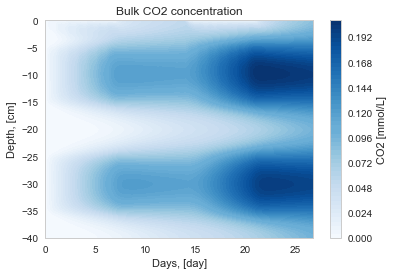

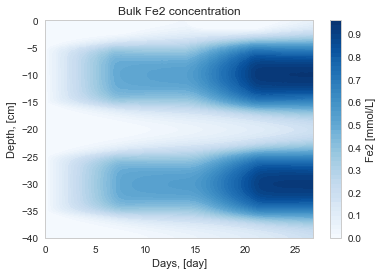

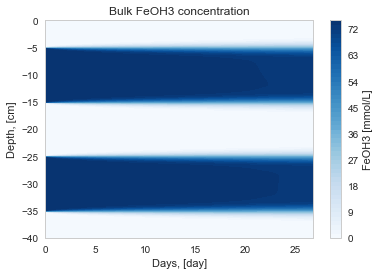

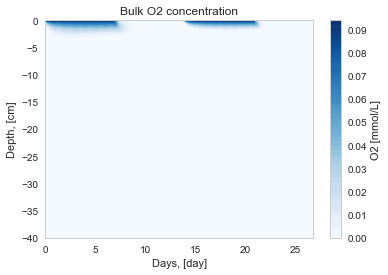

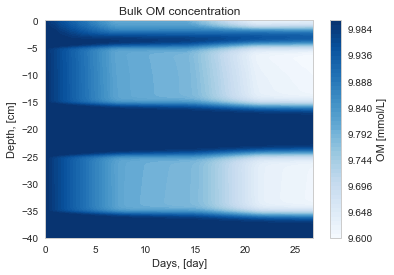

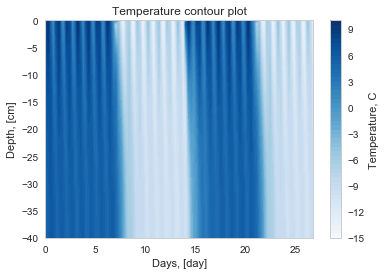

In [32]:
ftc.plot_contourplots()

### The rates of consumption and production of species:

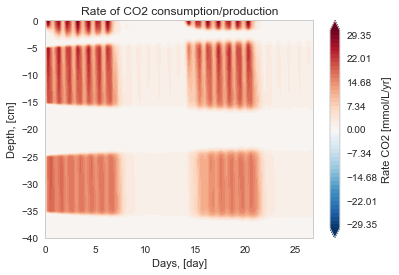

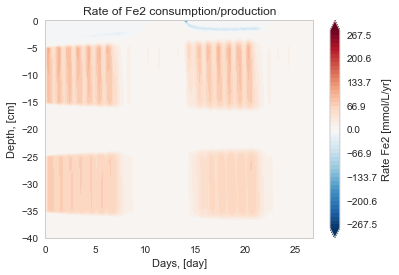

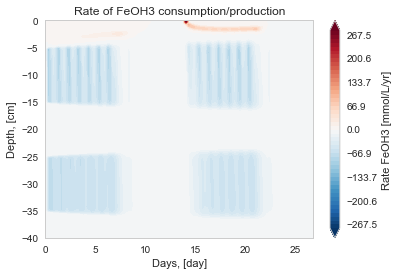

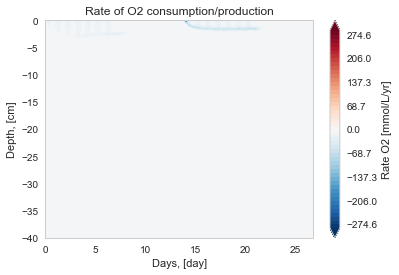

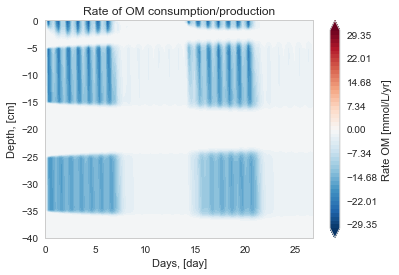

In [33]:
ftc.plot_contourplots_of_rates()

### Temperature timeseries at diferent depths:

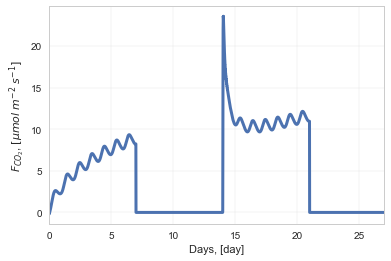

In [45]:
# C_top = ftc.CO2.concentration[0,:]
# Fx = phi * (C_top) / dx * 320
Fx = ftc.estimate_flux_at_top('CO2')
ftc.custom_plot(ftc.time*365, 10**3*10**4/(60*60*24*365)*(ftc.Temperature.concentration[0,:] > 0)*Fx,x_lbl='Days, [day]' , y_lbl='$F_{CO_2}$, $[\mu mol$ $m^{-2}$ $s^{-1}]$')
# Fx = ftc.estimate_flux_at_top_bc('CO2', order=3)
# ftc.custom_plot(ftc.time*365, 10**3*10**4/(60*60*24*365)*(ftc.Temperature.concentration[0,:] > 0)*Fx,x_lbl='Days, [day]' , y_lbl='$F_{CO_2}$, $[\mu mol$ $m^{-2}$ $s^{-1}]$')
# Fx = ftc.estimate_flux_at_top_bc('CO2', order=2)
# ftc.custom_plot(ftc.time*365, 10**3*10**4/(60*60*24*365)*(ftc.Temperature.concentration[0,:] > 0)*Fx,x_lbl='Days, [day]' , y_lbl='$F_{CO_2}$, $[\mu mol$ $m^{-2}$ $s^{-1}]$')
# Fx = ftc.estimate_flux_at_top_bc('CO2', order=1)
# ftc.custom_plot(ftc.time*365, 10**3*10**4/(60*60*24*365)*(ftc.Temperature.concentration[0,:] > 0)*Fx,x_lbl='Days, [day]' , y_lbl='$F_{CO_2}$, $[\mu mol$ $m^{-2}$ $s^{-1}]$')


In [ ]:
ftc.custom_plot(ftc.time*365, C_top)

In [ ]:
ftc.plot_depths("Temperature",[0,1,3,7,10,25,40])

### Temperatrure profiles during Freezing and Thawing cycles:

In [ ]:
t1 = np.linspace(6,7,11)/365
# tt = np.linspace(7,8,11)/365
t2 = np.linspace(13,14,11)/365
times = np.concatenate((t1, t2))
ftc.plot_times('Temperature', times)

### Profiles at the end of the simulation

In [ ]:
ftc.plot_profiles()

Simulation starts  with following params:
	tend = 5.0 years,
	dt = 1.00e-03 years,
	L = 100.0,
	dx = 1.00e-01,
	w = 5.00
Simulation started:
	 2017-05-03 12:11:25


Estimated time of the code execution:
	 0h:00m:03s
Will finish approx.:
	 2017-05-03 12:11:29


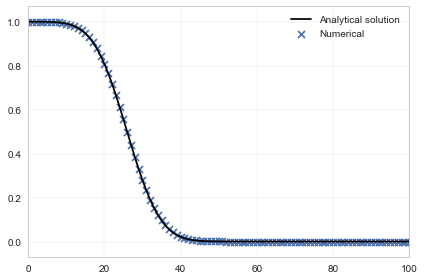

In [43]:
from PorousMediaLab import *
transport_equation_plot()

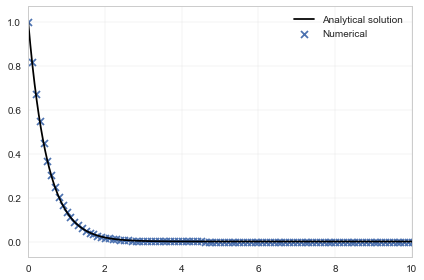

In [44]:
reaction_equation_plot()